#Implement Bounding Box around the affected location in the Chest XRay
- Loaded Train and Test from previously loaded and pickled files.
- Create MobileNet Regressor model with transfer learning
- Set Hyper parameters for optimal predictions to reduce the Loss on Train and Validation
- Run for appropriate epochs
- Predict the model on test data and check accuracy
Save the model for all future predictions
- Code for image manipulation and drawing the bounding box
- Other Models evaluated were Yolo, mobileNet with Unet 


In [ ]:
import pandas as pd
import numpy as np
import pickle as pk
import pylab
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
base_dir = "/content/drive/My Drive/CAPSTONE-PROJECT/rsna"
converted_imgs_dir = base_dir+"/convert_train_images1"

In [ ]:
df_train_labels = pd.read_csv(base_dir+"/stage_2_train_labels.csv")

In [ ]:
tr_x = "/content/drive/My Drive/TrainData/bb_trainX.npy"
tr_y = "/content/drive/My Drive/TrainData/bb_trainY.npy"


file = open(tr_x, 'rb')
bb_trainX = np.load(file)
file.close()
print("Loaded",tr_x)

file = open(tr_y, 'rb')
bb_trainY = np.load(file)
file.close()
print("Loaded",tr_y)

Loaded /content/drive/My Drive/TrainData/bb_trainX.npy
Loaded /content/drive/My Drive/TrainData/bb_trainY.npy


In [ ]:
tr_x = "/content/drive/My Drive/TrainData/bb_trainX.npy"
tr_y = "/content/drive/My Drive/TrainData/bb_trainY.npy"


file = open(tr_x, 'rb')
bb_trainX = np.load(file)
file.close()
print("Loaded",tr_x)

file = open(tr_y, 'rb')
bb_trainY = np.load(file)
file.close()
print("Loaded",tr_y)

In [ ]:
len(bb_trainX)

6650

In [ ]:
# SETTINGS

ALPHA = 1 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

HEIGHT_CELLS = 28
WIDTH_CELLS = 28

CELL_WIDTH = IMAGE_WIDTH / WIDTH_CELLS
CELL_HEIGHT = IMAGE_HEIGHT / HEIGHT_CELLS

PATIENCE = 10

THREADS = 1

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input 
from tensorflow.keras.layers import Conv2D, Reshape
from tensorflow.keras.models import Model
 
 
def create_mobilenet_model(trainable=True):  
  model = MobileNet(input_shape=(224, 224, 3), include_top=False, alpha=ALPHA,weights='imagenet')
  for layer in model.layers:
    layer.trainable = trainable
  x = model.layers[-1].output
  print(x.shape)
  print(x[0])
  x = Conv2D(4, kernel_size=7, name="coords")(x)
  print(x.shape)
  print(x[0])
  x = Reshape((4,))(x)
  print(x.shape)

  return Model(inputs=model.input, outputs=x)

In [ ]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return numerator / (denominator + tf.keras.backend.epsilon())

def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tf.log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())

In [ ]:
bb_mobilenet_model = create_mobilenet_model(False)
bb_mobilenet_model.summary()

17227776/17225924 [==============================] - 0s 0us/step
(None, 7, 7, 1024)
Tensor("strided_slice:0", shape=(7, 7, 1024), dtype=float32)
(None, 1, 1, 4)
Tensor("strided_slice_1:0", shape=(1, 1, 4), dtype=float32)
(None, 4)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
____________________________

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

bb_mobilenet_model.compile(loss="mean_squared_error", optimizer="adam", metrics=[]) # Regression loss is MSE

checkpoint = ModelCheckpoint("model-{val_iou:.2f}.h5", monitor="val_iou", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="max", period=1) # Checkpoint best validation model
stop = EarlyStopping(monitor=base_dir+"/val_iou", patience=PATIENCE, mode="max") # Stop early, if the validation error deteriorates
reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")
# Reduce learning rate if Validation IOU does not improve
bb_mobilenet_model.fit(bb_trainX,bb_trainY,batch_size=8,epochs=10)

Epoch 1/10
832/832 [==============================] - 19s 23ms/step - loss: 1015.4688
Epoch 2/10
832/832 [==============================] - 19s 23ms/step - loss: 756.1085
Epoch 3/10
832/832 [==============================] - 19s 23ms/step - loss: 641.9644
Epoch 4/10
832/832 [==============================] - 19s 23ms/step - loss: 582.2880
Epoch 5/10
832/832 [==============================] - 19s 23ms/step - loss: 559.9704
Epoch 6/10
832/832 [==============================] - 19s 23ms/step - loss: 542.9596
Epoch 7/10
832/832 [==============================] - 19s 23ms/step - loss: 522.8992
Epoch 8/10
832/832 [==============================] - 19s 23ms/step - loss: 517.1734
Epoch 9/10
832/832 [==============================] - 19s 23ms/step - loss: 511.6501
Epoch 10/10
832/832 [==============================] - 19s 23ms/step - loss: 517.8012


In [ ]:
bb_mobilenet_model.fit(bb_trainX,bb_trainY,batch_size=8,epochs=10)

Epoch 1/10
832/832 [==============================] - 19s 23ms/step - loss: 516.1624
Epoch 2/10
832/832 [==============================] - 19s 23ms/step - loss: 499.0616
Epoch 3/10
832/832 [==============================] - 19s 23ms/step - loss: 498.6952
Epoch 4/10
832/832 [==============================] - 19s 23ms/step - loss: 502.5400
Epoch 5/10
832/832 [==============================] - 19s 23ms/step - loss: 494.1148
Epoch 6/10
832/832 [==============================] - 19s 23ms/step - loss: 488.1987
Epoch 7/10
832/832 [==============================] - 19s 23ms/step - loss: 504.6363
Epoch 8/10
832/832 [==============================] - 19s 23ms/step - loss: 497.8156
Epoch 9/10
832/832 [==============================] - 19s 23ms/step - loss: 497.9520
Epoch 10/10
832/832 [==============================] - 19s 23ms/step - loss: 499.3596


In [ ]:
#Testing the model

In [ ]:
from sklearn import metrics
y_predict = bb_mobilenet_model.predict(bb_testX)
#metrics.classification_report


In [ ]:
srs = df_box['patientId']
df = df_train_labels[~df_train_labels.patientId.isin(srs)]
df = df[df['Target']==1]
df.head(30)

In [ ]:
from google.colab.patches import cv2_imshow

IMAGE_SIZE = 224
image_width,image_height=1024,1024
stroke=1

def get_image(im, region):
  x1 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
  y1 = int(region[1] * image_height / IMAGE_SIZE)

  x2 = int((region[0] + region[2]) * image_width / IMAGE_SIZE)
  y2 = int((region[1] + region[3]) * image_height / IMAGE_SIZE)

  im = unscaled
  # --- Convert from single-channel grayscale to 3-channel RGB
  rgb = np.floor(np.random.rand(3) * 256).astype('int')
  print(rgb)
  im[y1:y1 + stroke, x1:x2] = rgb
  im[y2:y2 + stroke, x1:x2] = rgb
  im[y1:y2, x1:x1 + stroke] = rgb
  im[y1:y2, x2:x2 + stroke] = rgb
  return im

[185  61 177]


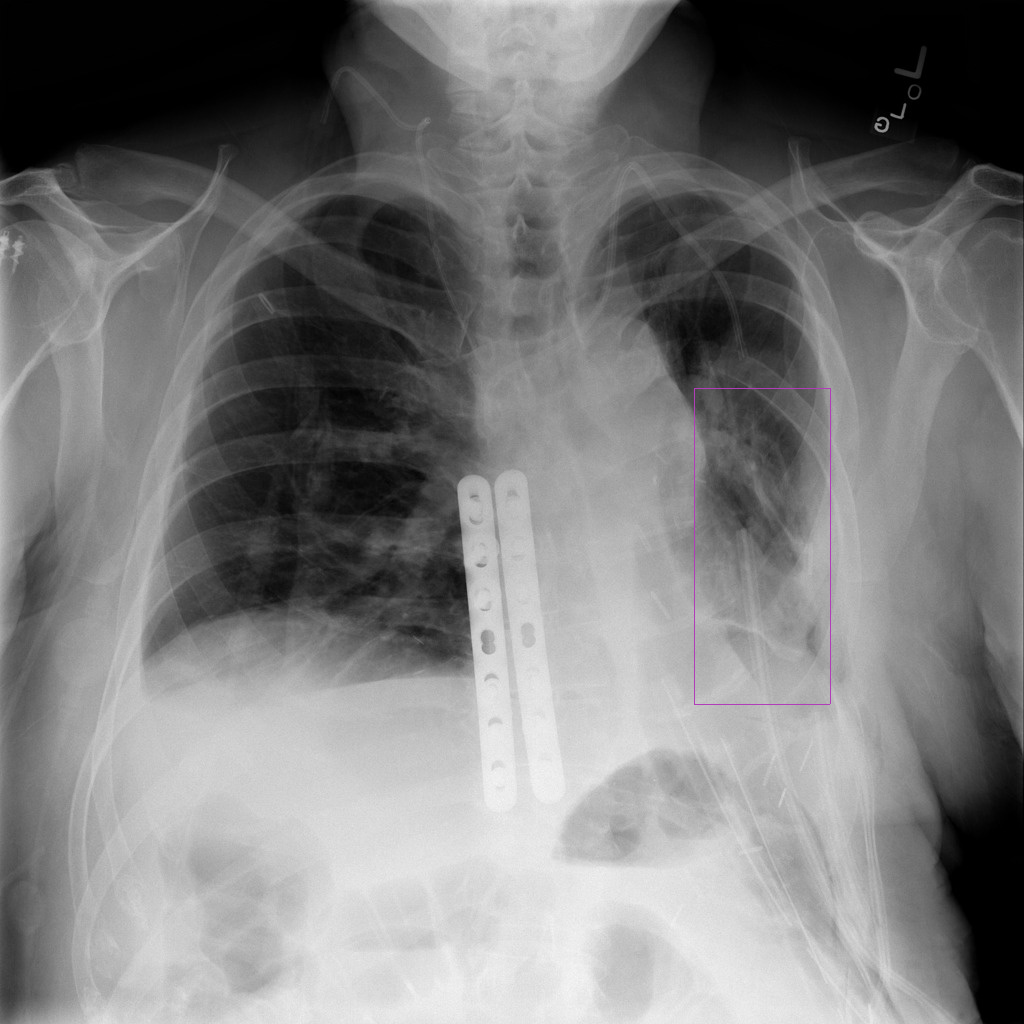

In [ ]:
idx = "01cd2ba5-2baf-44b2-bf15-ee57e1ea4599"
filename = converted_imgs_dir+"/"+idx+".jpg"

unscaled = cv2.imread(filename) # Original image for display
#cv2_imshow(unscaled)

#image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

region = loaded_model.predict(x=np.array([feat_scaled]))[0] # Predict the BBox
#print(region)
cv2_imshow(get_image(unscaled,region))

In [ ]:
bb_file = base_dir+"/"+"boundingbox_mobilenet_model"
bb_mobilenet_model.save(bb_file,overwrite=True)

#Summary
Successfully implemented Regressor to predict the affected region.
- Scale the Bounding Box Region data from 1024x1024, co-ordinates to 224x224
- Created MobileNet Regressor with transfer learning
- Ran the regressor for test and validation data
- Implemented CallBacks - checkpoints, Early Stopping, ReduceLROnPlateau
- Trained with various hyperparameters - Batch size, # of epochs, loss functions, learning rates
- The model has been run with acceptable Loss for train and validation.
- The model has then been used to predict with new XRays
- The following caliberations has been done for XRay predictions
  * The model has been trained for 224x224 images
  * Test images may be 1024x1024, this would first be rescaled to 224x224; model predicts the bounding box region for this image, this is then rescaled to 1024x1024.
  * The image is then displayed with 1024x1024 with adjusted bounding box
- Save the model for future use.
